# Gaussian process kernels

In [1]:
%matplotlib inline

import sys
import numpy as np
from numpy import exp, sin, pi, abs
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

sns.set_style('darkgrid')
np.random.seed(42)

DPI = 100
EPS = 1e-10  # Thikonov regularisation term

/home/peter/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/peter/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
from polynomial import Linear
from rational_quadratic import RationalQuadratic
psd_kernels.Linear = Linear
psd_kernels.RationalQuadratic = RationalQuadratic

## Kernel function

The [covariance](https://en.wikipedia.org/wiki/Covariance_function) can be modelled by a [kernel](https://en.wikipedia.org/wiki/Positive-definite_kernel) function $K(X,Y)$ that models how much the samples from $X$ and $Y$ change together. $K(X,Y)$ is positive if there is some similarity between the samples and will be zero if the samples are completely independent.

### Radial basis function kernel
A popular kernel is the [radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF) kernel: 

$$K(X,X') = \exp \left( -\frac{1}{2\sigma^2} \lVert X-X' \rVert^2 \right) $$

TODO: Multidimensional?

This kernel is illustrated in the next figure which shows the distance with respect to $0$: $K(0,y)$. Note that the similarity outputted by the kernel decreases exponentially towards $0$ the farther we move move away from the center, and that the similarity is maximum at the center $\mathbf{x}=\mathbf{y}$. Also note that the parameter $\sigma$ (width) defines how fast the similarity decreases. This means that the output of the RBF kernel function $K(\mathbf{x},\mathbf{y})$ is a similarity based on how close $\mathbf{x}$ lies to $\mathbf{y}$, the greater $\sigma$ is, the greater this distance effect.

aka
- Guassian kernel
- Squared exponention

Smooth?
- https://en.wikipedia.org/wiki/Gaussian_blur#Low-pass_filter
- https://en.wikipedia.org/wiki/Gaussian_filter
- https://calculatedcontent.com/2012/02/06/kernels_part_1/
- http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/
- https://www.quora.com/Support-Vector-Machines/What-is-the-intuition-behind-Gaussian-kernel-in-SVM-How-can-I-visualize-the-transformation-function-%CF%95-that-corresponds-to-the-Gaussian-kernel-Why-is-the-Gaussian-kernel-popular
- https://stats.stackexchange.com/questions/131138/what-makes-the-gaussian-kernel-so-magical-for-pca-and-also-in-general

Using the RBF kernel will result in [smooth](https://en.wikipedia.org/wiki/Smoothness) functions sampled from the Gaussian process.

### Prior
The specification of this covariance function implies a distribution over functions $f(X)$. By choosing a specific kernel function $K$ it possible to set some [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. For example the RBF kernel captures the prior information that the data lies in a [smooth](https://en.wikipedia.org/wiki/Smoothness) space. This is because it is infinitely differentiable over its full range. I will illustrate this more later in this tutorial.

### Valid kernels
In order to be a valid kernel function the resulting kernel matrix should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Which means that the matrix should be [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix) since $K(\mathbf{x},\mathbf{y}) = K(\mathbf{y},\mathbf{x})$, and that the output of the kernel function should be positive ($K(\mathbf{x},\mathbf{y}) \geq 0$). Being positive definite also means that the kernel matrix is [invertable](https://en.wikipedia.org/wiki/Invertible_matrix).

In [3]:
def plot_kernel(X, y, Σ, description, fig, subplot_spec, xlim,
                scatter=False, rotate_x_labels=False):
    grid_spec = gridspec.GridSpecFromSubplotSpec(
        1, 2, width_ratios=[2,1], height_ratios=[1],
        wspace=0.18, hspace=0.0,
        subplot_spec=subplot_spec)
    ax1 = fig.add_subplot(grid_spec[0])
    ax2 = fig.add_subplot(grid_spec[1])
    # Plot samples
    if scatter:
        for i in range(y.shape[1]):
            ax1.scatter(X, y[:,i], alpha=0.8, s=3)
    else:
        for i in range(y.shape[1]):
            ax1.plot(X, y[:,i], alpha=0.8)
    ax1.set_ylabel('$y$', fontsize=13, labelpad=0)
    ax1.set_xlabel('$x$', fontsize=13, labelpad=0)
    ax1.set_xlim(xlim)
    if rotate_x_labels:
        for l in ax1.get_xticklabels():
            l.set_rotation(30)
    ax1.set_title(f'Samples from {description}')
    # Plot covariance matrix
    im = ax2.imshow(Σ, cmap=cm.YlGnBu)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.02)
    cbar = plt.colorbar(im, ax=ax2, cax=cax)
    cbar.ax.set_ylabel('$K(X,X)$', fontsize=8)
    ax2.set_title(f'Covariance matrix\n{description}')
    ax2.set_xlabel('X', fontsize=10, labelpad=0)
    ax2.set_ylabel('X', fontsize=10, labelpad=0)
    ticks = list(range(xlim[0], xlim[1]+1))
    ax2.set_xticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_yticks(np.linspace(0, len(X), len(ticks)))
    ax2.set_xticklabels(ticks)
    ax2.set_yticklabels(ticks)
    if rotate_x_labels:
        for l in ax2.get_xticklabels():
            l.set_rotation(30)
    ax2.grid(False)

# White noise kernel

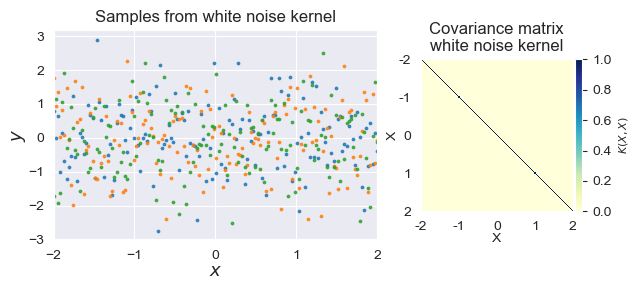

In [26]:
nb_of_samples = 150  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate independent samples that can be transformed
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(6.5, 3), dpi=DPI) 
gs = gridspec.GridSpec(
    1, 1, figure=fig, wspace=0.0, hspace=0.0)

# Sample from the prior
Σ = np.eye(nb_of_samples)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
# Plot
plot_kernel(
    X, y, Σ, 'white noise kernel', 
    fig, gs[0], xlim, scatter=True)
plt.tight_layout()
plt.show()

# Exponentiated quadratic

In [5]:
def exponentiated_quadratic_tf(amplitude, length_scale):
    amplitude_tf = tf.constant(amplitude, dtype=tf.float64)
    length_scale_tf = tf.constant(length_scale, dtype=tf.float64)
    kernel = psd_kernels.ExponentiatedQuadratic(
        amplitude=amplitude_tf, 
        length_scale=length_scale_tf)
    return kernel
                                  

def exponentiated_quadratic(xa, xb, amplitude, length_scale):
    kernel = exponentiated_quadratic_tf(amplitude, length_scale)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

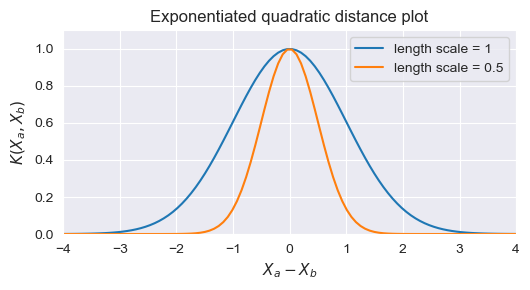

In [6]:
# Plot some kernel values of y with respect to 0
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0.]])
Σ1 = exponentiated_quadratic(
    zero, X, length_scale=1, amplitude=1)
Σ2 = exponentiated_quadratic(
    zero, X, length_scale=0.5, amplitude=1)
# Make the plots
fig, ax = plt.subplots(figsize=(5.4,3), dpi=DPI)
ax.plot(X[:,0], Σ1[0,:], label='length scale = 1')
ax.plot(X[:,0], Σ2[0,:], label='length scale = 0.5')
ax.set_xlabel('$X_a - X_b$', fontsize=11)
ax.set_ylabel('$K(X_a,X_b)$', fontsize=11)
ax.set_title('Exponentiated quadratic distance plot')
ax.set_ylim([0, 1.1])
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()
#

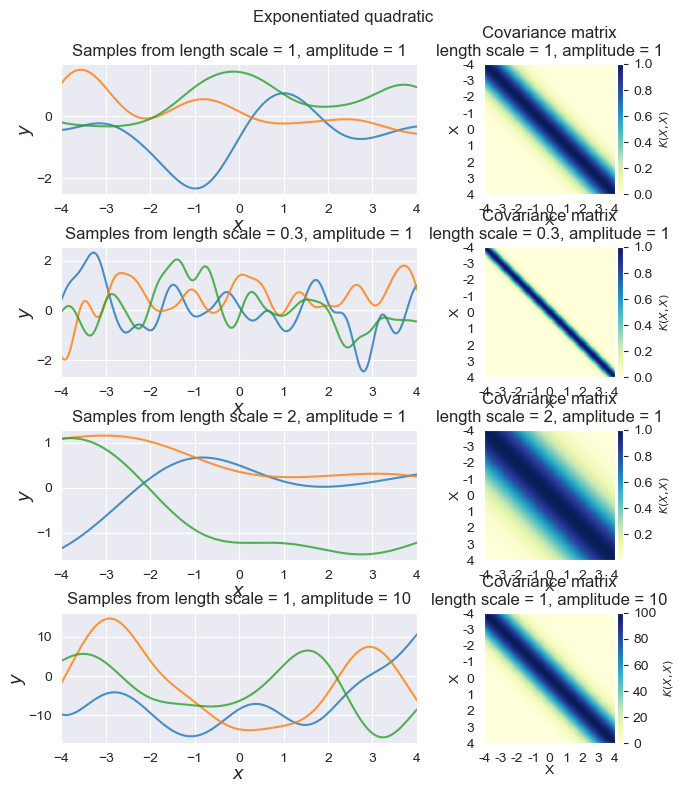

In [30]:
nb_of_samples = 250  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7.5, 9), dpi=DPI) 
gs = gridspec.GridSpec(
    4, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = exponentiated_quadratic(
    X, X, length_scale=1, amplitude=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 1', 
    fig, gs[0], xlim)

# Plot second
Σ = exponentiated_quadratic(
    X, X, length_scale=0.3, amplitude=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 0.3, amplitude = 1', 
    fig, gs[1], xlim)

# Plot second
Σ = exponentiated_quadratic(
    X, X, length_scale=2, amplitude=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 2, amplitude = 1', 
    fig, gs[2], xlim)

# Plot third
Σ = exponentiated_quadratic(
    X, X, length_scale=1, amplitude=10)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[3], xlim)

plt.suptitle('Exponentiated quadratic', y=0.94)
plt.show()
#

### RBF kernel as smooth prior

Note that the identity matrix $I$ contains ones on the diagonal and zeros everywhere else. This means that all samples taken from $\mathcal{N}(0,I)$ are independent of eachother and we can just sample each sample seperately. These independent samples are then transformed with the help of the linear transformation $L$ that maps the independent samples to a space where they are more correlated. This correlation is defined by the kernel matrix $K=LL^\top$.  
The next figures illustrate how increasing the width $\sigma$ of the kernel increases it smoothnes.

## Rational Quadratic

In [8]:
def rational_quadratic_tf(length_scale, scale_mixture, amplitude):
    amplitude_tf = tf.constant(amplitude, dtype=tf.float64)
    length_scale_tf = tf.constant(length_scale, dtype=tf.float64)
    scale_mixture_tf = tf.constant(scale_mixture, dtype=tf.float64)
    kernel = psd_kernels.RationalQuadratic(
        amplitude=amplitude_tf,
        length_scale=length_scale_tf,
        scale_mixture_rate=scale_mixture_tf)
    return kernel


def rational_quadratic(xa, xb, length_scale, scale_mixture):
    kernel = rational_quadratic_tf(length_scale, scale_mixture, 1)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

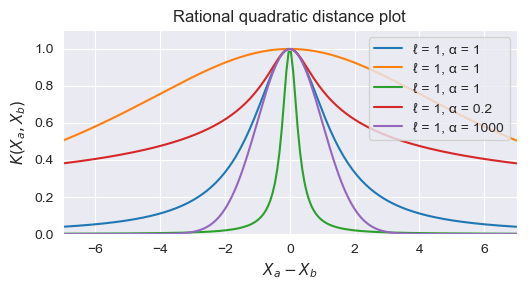

In [27]:
# Plot some kernel values of y with respect to 0
xlim = (-7, 7)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])
# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=DPI)
Σ = rational_quadratic(
    zero, X, length_scale=1, scale_mixture=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, α = 1')
Σ = rational_quadratic(
    zero, X, length_scale=5, scale_mixture=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, α = 1')
Σ = rational_quadratic(
    zero, X, length_scale=0.2, scale_mixture=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, α = 1')
Σ = rational_quadratic(
    zero, X, length_scale=1, scale_mixture=0.2)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, α = 0.2')
Σ = rational_quadratic(
    zero, X, length_scale=1, scale_mixture=1000)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, α = 1000')

ax.set_xlabel('$X_a - X_b$', fontsize=11)
ax.set_ylabel('$K(X_a,X_b)$', fontsize=11)
ax.set_title('Rational quadratic distance plot')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
plt.tight_layout()
plt.show()
#

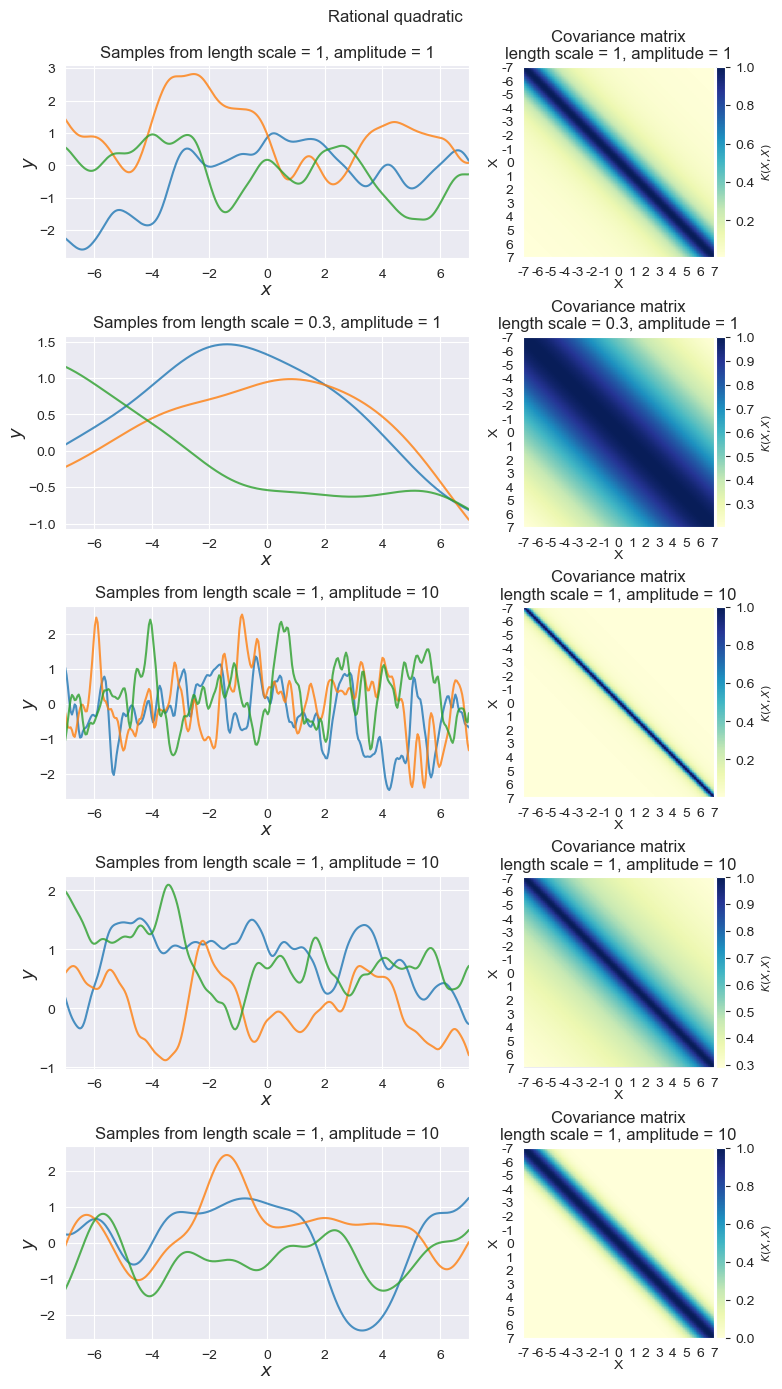

In [10]:
nb_of_samples = 300  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-7, 7)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7.5, 14), dpi=DPI) 
gs = gridspec.GridSpec(
    5, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = rational_quadratic(
    X, X, length_scale=1, scale_mixture=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 1', 
    fig, gs[0], xlim)

# Plot second
Σ = rational_quadratic(
    X, X, length_scale=5, scale_mixture=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 0.3, amplitude = 1', 
    fig, gs[1], xlim)

# Plot third
Σ = rational_quadratic(
    X, X, length_scale=0.2, scale_mixture=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[2], xlim)

# Plot fourth
Σ = rational_quadratic(
    X, X, length_scale=1, scale_mixture=0.2)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[3], xlim)

# Plot fifth
Σ = rational_quadratic(
    X, X, length_scale=1, scale_mixture=1000)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[4], xlim)

fig.suptitle('Rational quadratic', y=0.99)
fig.subplots_adjust(
    left=0.06, bottom=0.04, right=0.94, top=0.95)
plt.show()
#

## Periodic

$$
K(X,X') = \exp \left(-\frac{2}{l^2} \sin^2 \left( \pi \frac{ \lvert X-X' \rvert}{p} \right) \right)
$$

In [11]:
def periodic_tf(length_scale, period):
    amplitude_tf = tf.constant(1, dtype=tf.float64)
    length_scale_tf = tf.constant(length_scale, dtype=tf.float64)
    period_tf = tf.constant(period, dtype=tf.float64)
    kernel = psd_kernels.ExpSinSquared(
        amplitude=amplitude_tf, 
        length_scale=length_scale_tf,
        period=period_tf)
    return kernel

def periodic(xa, xb, length_scale, period):
    kernel = periodic_tf(length_scale, period)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

/home/peter/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


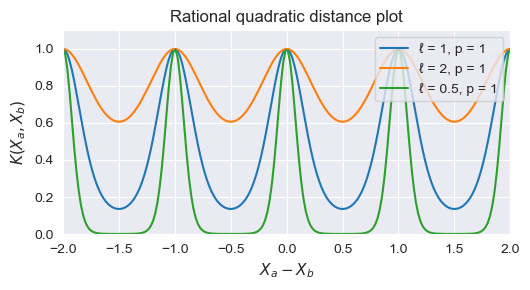

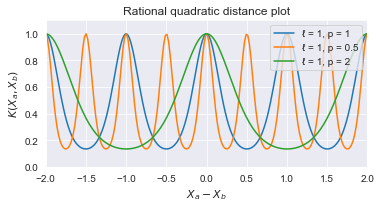

In [12]:
# Plot some kernel values of y with respect to 0
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=DPI)
Σ = periodic(
    zero, X, length_scale=1, period=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = periodic(
    zero, X, length_scale=2, period=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 2, p = 1')
Σ = periodic(
    zero, X, length_scale=0.5, period=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 0.5, p = 1')
ax.set_xlabel('$X_a - X_b$', fontsize=11)
ax.set_ylabel('$K(X_a,X_b)$', fontsize=11)
ax.set_title('Rational quadratic distance plot')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
fig.show()

# Make the plots
fig, ax = plt.subplots(figsize=(5.4,3))
Σ = periodic(
    zero, X, length_scale=1, period=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = periodic(
    zero, X, length_scale=1, period=0.5)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 0.5')
Σ = periodic(
    zero, X, length_scale=1, period=2)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 2')
ax.set_xlabel('$X_a - X_b$', fontsize=11)
ax.set_ylabel('$K(X_a,X_b)$', fontsize=11)
ax.set_title('Rational quadratic distance plot')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

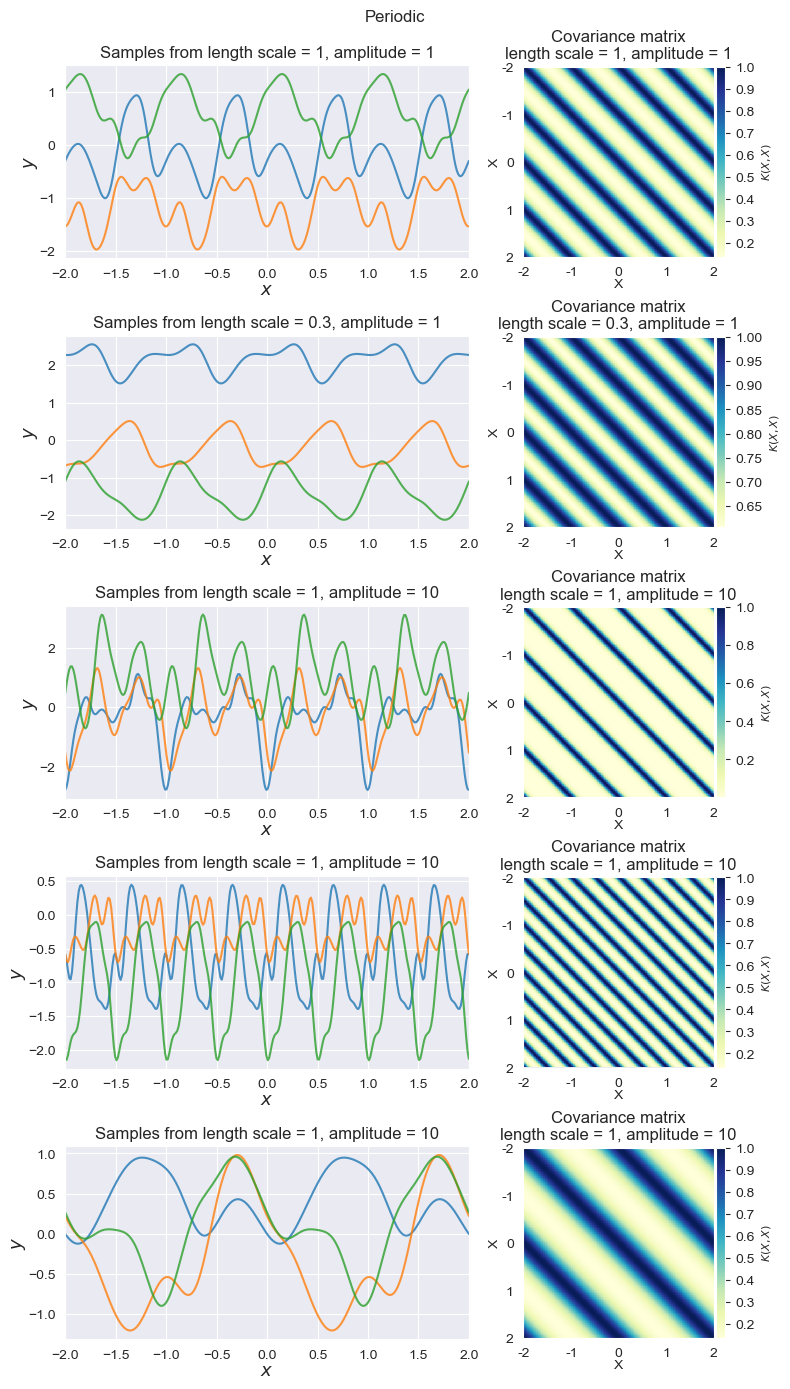

In [13]:
nb_of_samples = 300  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7.5, 14), dpi=DPI) 
gs = gridspec.GridSpec(
    5, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = periodic(
    X, X, length_scale=1, period=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 1', 
    fig, gs[0], xlim)

# Plot second
Σ = periodic(
    X, X, length_scale=2, period=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 0.3, amplitude = 1', 
    fig, gs[1], xlim)

# Plot third
Σ = periodic(
    X, X, length_scale=0.5, period=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[2], xlim)

# Plot fourth
Σ = periodic(
    X, X, length_scale=1, period=0.5)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[3], xlim)

# Plot fifth
Σ = periodic(
    X, X, length_scale=1, period=2)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[4], xlim)

fig.suptitle('Periodic', y=0.99)
fig.subplots_adjust(
    left=0.06, bottom=0.04, right=0.94, top=0.95)
plt.show()
#

## Linear kernel

In [14]:
def linear_tf(slope, bias, intercept):
    slope_tf = tf.constant(slope, dtype=tf.float64)
    bias_tf = tf.constant(bias, dtype=tf.float64)
    intercept_tf = tf.constant(intercept, dtype=tf.float64)
    kernel = psd_kernels.Linear(
        slope_variance=slope_tf,
        bias_variance=bias_tf,
        intercept=intercept_tf)
    return kernel

def linear(xa, xb, slope, bias, intercept):
    kernel = linear_tf(slope, bias, intercept)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

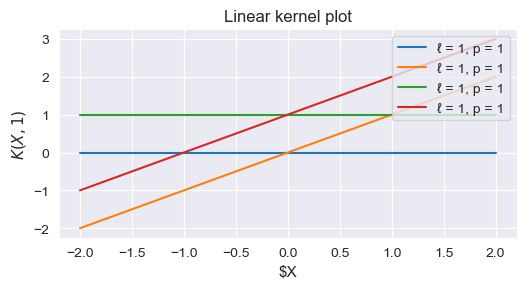

In [15]:
# Plot some kernel values of y with respect to 0
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
one = np.array([[1.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=DPI)
Σ = linear(
    one, X, slope=0, bias=0, intercept=0)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = linear(
    one, X, slope=1, bias=0, intercept=0)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = linear(
    one, X, slope=0, bias=1, intercept=0)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = linear(
    one, X, slope=1, bias=1, intercept=0)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
ax.set_xlabel('$X', fontsize=11)
ax.set_ylabel('$K(X, 1)$', fontsize=11)
ax.set_title('Linear kernel plot')
# ax.set_ylim((0, 1.1))
# ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

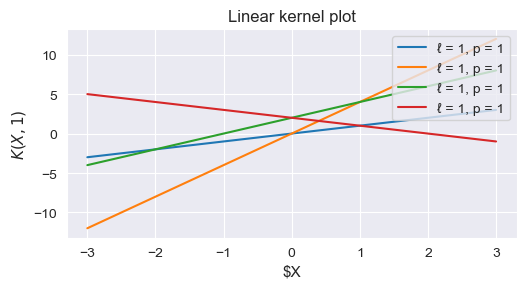

In [16]:
# Plot some kernel values of y with respect to 0
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
one = np.array([[1.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=DPI)
Σ = linear(
    one, X, slope=1, bias=0, intercept=0)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = linear(
    one, X, slope=2, bias=0, intercept=0)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = linear(
    one, X, slope=1, bias=0, intercept=-1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = linear(
    one, X, slope=1, bias=0, intercept=2)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
# Σ = linear(
#     one, X, slope=1, bias=0, intercept=2)
# ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
# Σ = linear(
#     one, X, slope=1, bias=1, intercept=0)
# ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
# Σ = linear(
#     one, X, slope=2, bias=0)
# ax.plot(X[:,0], Σ[0,:], label='ℓ = 2, p = 1')
# Σ = linear(
#     one, X, slope=1, bias=1)
# ax.plot(X[:,0], Σ[0,:], label='ℓ = 0.5, p = 1')
ax.set_xlabel('$X', fontsize=11)
ax.set_ylabel('$K(X, 1)$', fontsize=11)
ax.set_title('Linear kernel plot')
# ax.set_ylim((0, 1.1))
# ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

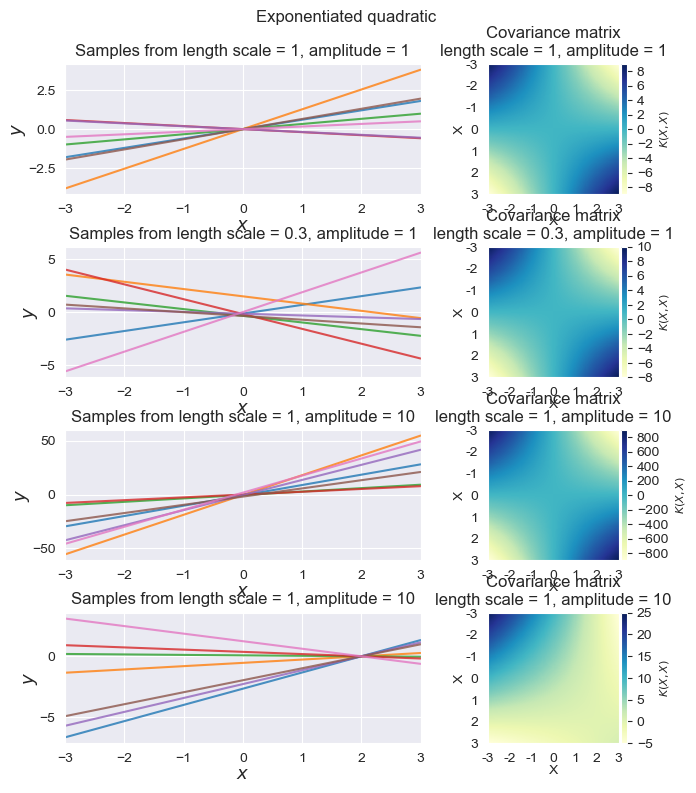

In [17]:
nb_of_samples = 250  # Number of test points.
nb_of_realizations = 7  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7.5, 9), dpi=DPI) 
gs = gridspec.GridSpec(
    4, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = linear(
    X, X, slope=1, bias=0, intercept=0)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 1', 
    fig, gs[0], xlim)

# Plot second
Σ = linear(
    X, X, slope=1, bias=1, intercept=0)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 0.3, amplitude = 1', 
    fig, gs[1], xlim)

# Plot third
Σ = linear(
    X, X, slope=10, bias=1, intercept=0)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[2], xlim)


# Plot fourth
Σ = linear(
    X, X, slope=1, bias=0, intercept=2)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[3], xlim)

fig.suptitle('Exponentiated quadratic', y=0.94)
plt.show()
#

## Local periodic

In [18]:
def local_periodic_tf(periodic_length_scale, period, 
                      amplitude, local_length_scale):
    periodic_length_scale_tf = tf.constant(
        periodic_length_scale, dtype=tf.float64)
    period_tf = tf.constant(period, dtype=tf.float64)
    amplitude_tf = tf.constant(amplitude, dtype=tf.float64)
    local_length_scale_tf = tf.constant(
        local_length_scale, dtype=tf.float64)
    kernel = (
        psd_kernels.ExpSinSquared(
            amplitude=amplitude_tf, 
            length_scale=periodic_length_scale_tf,
            period=period_tf) *
        psd_kernels.ExponentiatedQuadratic(
            length_scale=local_length_scale_tf))
    return kernel


def local_periodic(xa, xb, periodic_length_scale, period, 
                   amplitude, local_length_scale):
    kernel = local_periodic_tf(periodic_length_scale, period, 
        amplitude, local_length_scale)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

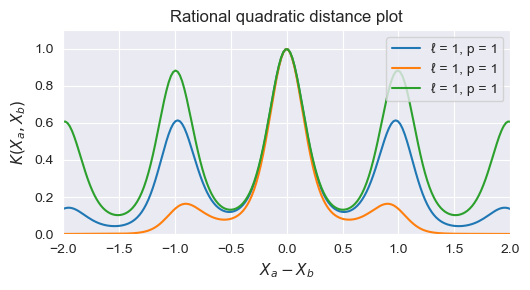

In [19]:
# Plot some kernel values of y with respect to 0
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, num=200), 1)
zero = np.array([[0.]])

# Make the plots
fig, ax = plt.subplots(figsize=(5.4, 3), dpi=DPI)
Σ = local_periodic(
    zero, X, 
    periodic_length_scale=1, period=1, amplitude=1, 
    local_length_scale=1)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = local_periodic(
    zero, X, 
    periodic_length_scale=1, period=1, amplitude=1, 
    local_length_scale=0.5)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
Σ = local_periodic(
    zero, X, 
    periodic_length_scale=1, period=1, amplitude=1, 
    local_length_scale=2)
ax.plot(X[:,0], Σ[0,:], label='ℓ = 1, p = 1')
ax.set_xlabel('$X_a - X_b$', fontsize=11)
ax.set_ylabel('$K(X_a,X_b)$', fontsize=11)
ax.set_title('Rational quadratic distance plot')
ax.set_ylim((0, 1.1))
ax.set_xlim(*xlim)
ax.legend(loc=1)
fig.tight_layout()
plt.show()
#

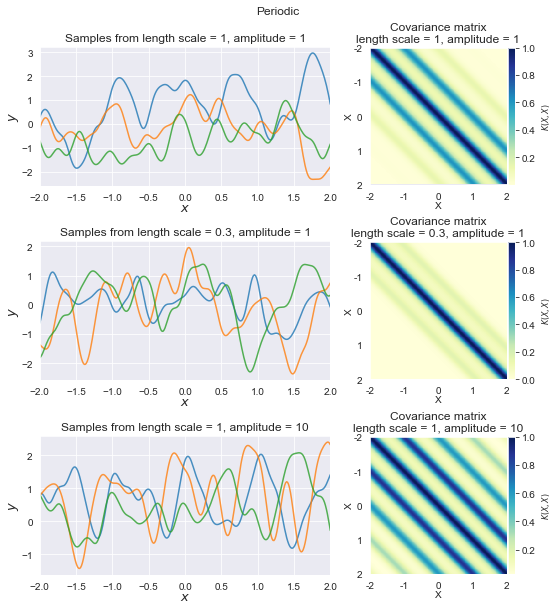

In [20]:
nb_of_samples = 300  # Number of test points.
nb_of_realizations = 3  # Number of function realizations
# Generate input points
xlim = (-2, 2)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7.5, 14)) 
gs = gridspec.GridSpec(
    5, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = local_periodic(
    X, X, 
    periodic_length_scale=1, period=1, amplitude=1, 
    local_length_scale=1)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 1', 
    fig, gs[0], xlim)

# Plot second
Σ = local_periodic(
    X, X, 
    periodic_length_scale=1, period=1, amplitude=1, 
    local_length_scale=0.5)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 0.3, amplitude = 1', 
    fig, gs[1], xlim)

# Plot third
Σ = local_periodic(
    X, X, 
    periodic_length_scale=1, period=1, amplitude=1, 
    local_length_scale=2)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[2], xlim)

# Plot fourth
# Σ = local_periodic(
#     X, X, 
#     periodic_length_scale=1, period=1, amplitude=1, 
#     local_length_scale=1)
# y = np.random.multivariate_normal(
#     mean=np.zeros(nb_of_samples), cov=Σ, 
#     size=nb_of_realizations).T
# plot_kernel(
#     X, y, Σ, 'length scale = 1, amplitude = 10', 
#     fig, gs[3], xlim)

# # Plot fifth
# Σ = local_periodic(
#     X, X, 
#     periodic_length_scale=1, period=1, amplitude=1, 
#     local_length_scale=1)
# y = np.random.multivariate_normal(
#     mean=np.zeros(nb_of_samples), cov=Σ, 
#     size=nb_of_realizations).T
# plot_kernel(
#     X, y, Σ, 'length scale = 1, amplitude = 10', 
#     fig, gs[4], xlim)

fig.suptitle('Periodic', y=0.99)
fig.subplots_adjust(
    left=0.06, bottom=0.04, right=0.94, top=0.95)
plt.show()
#

## Local linear

In [21]:
def local_linear_tf(slope, bias, intercept, amplitude, length_scale):
    slope_tf = tf.constant(slope, dtype=tf.float64)
    bias_tf = tf.constant(bias, dtype=tf.float64)
    amplitude_tf = tf.constant(bias, dtype=tf.float64)
    length_scale_tf = tf.constant(length_scale, dtype=tf.float64)
    intercept_tf = tf.constant(intercept, dtype=tf.float64)
    kernel = (
        psd_kernels.Linear(
            slope_variance=slope_tf,
            bias_variance=bias_tf,
            intercept=intercept_tf) *
        psd_kernels.ExponentiatedQuadratic(
            amplitude=amplitude_tf, 
            length_scale=length_scale_tf))
    return kernel

def local_linear(xa, xb, slope, bias, intercept, amplitude, length_scale):
    kernel = local_linear_tf(slope, bias, intercept, amplitude, length_scale)
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)

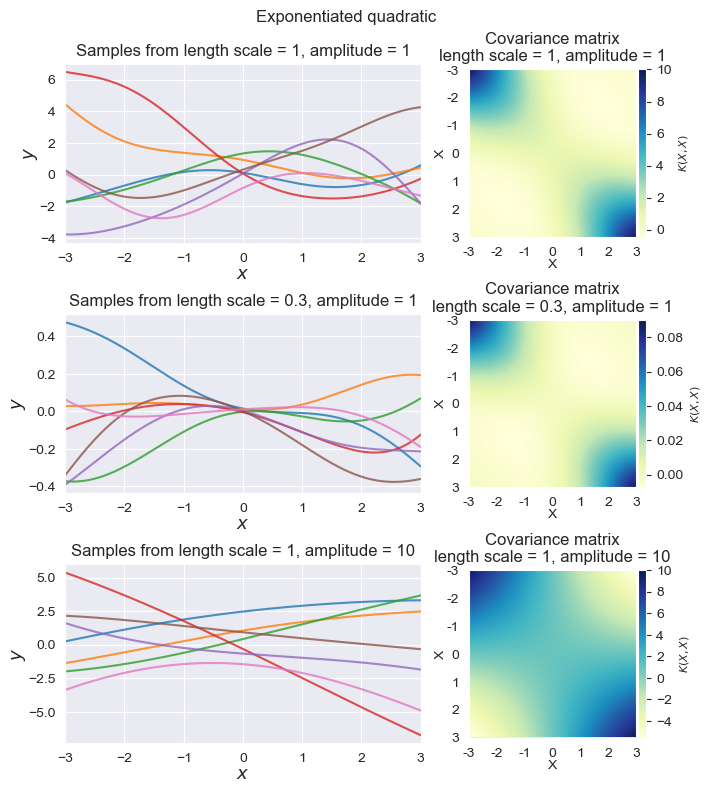

In [22]:
nb_of_samples = 250  # Number of test points.
nb_of_realizations = 7  # Number of function realizations
# Generate input points
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7.5, 9), dpi=DPI) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = local_linear(
    X, X, slope=1, bias=1, intercept=0., amplitude=1, length_scale=2)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 1', 
    fig, gs[0], xlim)

# Plot second
Σ = local_linear(
    X, X, slope=1, bias=0.1, intercept=0., amplitude=10, length_scale=2)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 0.3, amplitude = 1', 
    fig, gs[1], xlim)

# # Plot third
Σ = local_linear(
    X, X, slope=1, bias=1, intercept=0, amplitude=1, length_scale=7)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 10', 
    fig, gs[2], xlim)

fig.suptitle('Exponentiated quadratic', y=0.94)
plt.show()
#

## Combined kernel

In [23]:
def combined_kernel_tf():
    smooth_kernel = exponentiated_quadratic_tf(
        amplitude=256.2744, 
        length_scale=154.6645)
    local_trend_kernel = local_linear_tf(
        slope=0.5510, 
        bias=8.2980, 
        intercept=1984.6574,
        amplitude=1.,
        length_scale=202.9539)
    local_periodic_kernel = local_periodic_tf(
        periodic_length_scale=1.6440, 
        period=0.9997, 
        amplitude=3.3774, 
        local_length_scale=162.2543)
    irregular_kernel = rational_quadratic_tf(
        length_scale=3.7100, 
        scale_mixture=0.0098,
        amplitude=2.9896)  
    return (smooth_kernel + 
        local_trend_kernel +
        local_periodic_kernel +
        irregular_kernel)

# def combined_kernel_tf():
#     smooth_kernel = exponentiated_quadratic_tf(
#         amplitude=22.9892, 
#         length_scale=112.0986)
#     local_trend_kernel = local_linear_tf(
#         slope=1.1320, 
#         bias=5.3528, 
#         intercept=1993.8546,
#         amplitude=1.,
#         length_scale=537.8422)
#     local_periodic_kernel = local_periodic_tf(
#         periodic_length_scale=1.5204, 
#         period=0.9997, 
#         amplitude=2.8079, 
#         local_length_scale=139.8558)
#     irregular_kernel = rational_quadratic_tf(
#         length_scale=3.8044, 
#         scale_mixture=0.0097,
#         amplitude=3.0353)  
#     return (smooth_kernel + 
#         local_trend_kernel +
#         local_periodic_kernel +
#         irregular_kernel)

def combined_kernel(xa, xb):
    kernel = combined_kernel_tf()
    kernel_matrix = kernel.matrix(xa, xb)
    with tf.Session() as sess:
        return sess.run(kernel_matrix)
    



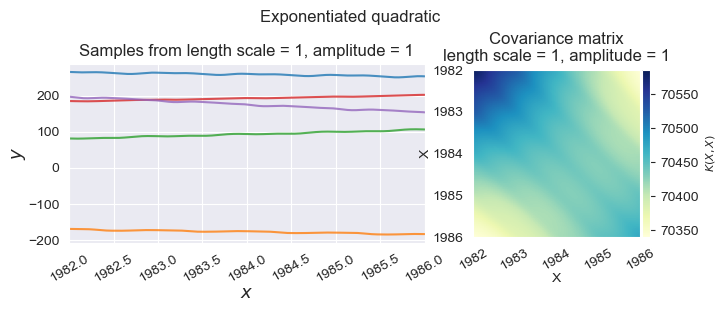

In [24]:
nb_of_samples = 250  # Number of test points.
nb_of_realizations = 5  # Number of function realizations
# Generate input points
xlim = (1982, 1986)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# Start plotting
fig = plt.figure(figsize=(7.5, 9), dpi=DPI) 
gs = gridspec.GridSpec(
    3, 1, figure=fig, wspace=0.2, hspace=0.4)

# Plot first
Σ = combined_kernel(X, X)
y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=nb_of_realizations).T
plot_kernel(
    X, y, Σ, 'length scale = 1, amplitude = 1', 
    fig, gs[0], xlim, rotate_x_labels=True)

fig.suptitle('Exponentiated quadratic', y=0.94)
plt.show()
#

In [25]:
# Print versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(scipy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.6.6
numpy: 1.15.1
scipy: 1.1.0
matplotlib: 2.2.3
seaborn: 0.9.0


- https://www.cs.toronto.edu/~duvenaud/cookbook/
- http://www.gaussianprocess.org/gpml/chapters/RW4.pdf
- file:///home/peter/Downloads/holiday/kernels.pdf
- https://mlkernels.readthedocs.io/en/latest/kernels.html
- http://ml.dcs.shef.ac.uk/gpss/gpws14/KernelDesign.pdf